In [3]:
import arbor as A
import matplotlib.pyplot as plt

# Setup the Parameters

In [4]:
ncells = 4
T = 150

# Configure the Simulation

We will use almost the same setup, however, we are going to use a more complicated cell type, so called *cable cell*.
The name stems from the underlying physical model, the cable equation
\begin{equation*}
C_m \partial_t U = \sigma \Delta U + I_m\,,
\end{equation*}
which is solved for discrete *compartments* (control volumes in FVM).  Arbor uses a (slightly more complex) version of this.

## Morphologies

What do we actually turn into compartments? 
In the cable model, each cell has a bit of geometric (actually topological) information attached, the morphology.
This is what differentiates Neuron, Arbor, and others from point models.

![yes](tag_label.png)

Here, we load the morphology from disk in a standard format. Often these come from a tissue scan.

In [8]:
morph = A.load_swc_neuron('my-morph.swc')

## Ion Channels, Parameters, and Regions

The transmembrane currents $I_m$ drive the dynamics of each compartment, they are described via *ion channel* models.
Each group of compartments might have its own set of ion channels and, similarly, parameters might vary over compartments.
So, we will need a method to describe subsets of the morphology where to apply these things.
Similarly, point-like things -- current clamps, spike detectors, ... -- now have a location, too.

In Arbor, we handle these via a *decor*

In [50]:
soma = '(tag 1)'
dend = '(tag 3)'
cntr = '(on-components 0.49 (tag 1))'

decor = (
    A.decor()
    # Put hh dynamics on soma
    .paint(soma, A.density("hh"))
    # add a leaky current everywhere else
    .paint(dend, A.density("pas"))
    # Attach a single exponential synapse.
    .place(cntr, A.synapse("expsyn"), "synapse")
    # Attach a detector with threshold of -10 mV.
    .place(cntr, A.threshold_detector(-10), "detector")
)

Now we can build our recipe, just as before.

In [51]:
class ring(A.recipe):

    def __init__(self, ncells):
        A.recipe.__init__(self) # NEVER forget this!
        self.ncells = ncells
        self.weight = 0.01
        self.delay  = 5    # ms
        self.t_inj  = [10, ] # ms
        self.properties = A.neuron_cable_properties()

    def num_cells(self):
        return self.ncells

    def cell_description(self, gid):
        return A.cable_cell(morph, decor)

    def cell_kind(self, gid):
        return A.cell_kind.cable

    def connections_on(self, gid):
        src = (gid - 1) % self.ncells
        return [A.connection((src, "detector"), "synapse", self.weight, self.delay)]

    def event_generators(self, gid):
        if gid == 0:
            sched = A.explicit_schedule(self.t_inj)
            return [A.event_generator("synapse", self.weight*10, sched)]
        return []

    def probes(self, gid):
        return [A.cable_probe_membrane_voltage(cntr)]

    def global_properties(self, kind):
        return self.properties

# Turn the Recipe into an Executable Object

Make a concrete instance of the recipe ... Yeah, same as ever ;)

In [52]:
rec = ring(ncells)
sim = A.simulation(rec)
sim.record(A.spike_recording.all)
# This API is a bit weird and will soon improve!
hdl = [sim.sample((gid, 0), A.regular_schedule(0.1)) for gid in range(ncells)]

# Run it!

In [53]:
sim.run(150)

150.0

# Inspect Spikes

In [54]:
print("Spikes:")

spikes = [[] for _ in range(ncells)]

for (gid, lid), t in sim.spikes():
    print(f" ^ {t:9.2f}ms cell={gid} detector={lid}")
    spikes[gid].append(t)

Spikes:
 ^     10.33ms cell=0 detector=0
 ^     16.82ms cell=1 detector=0
 ^     23.28ms cell=2 detector=0
 ^     29.75ms cell=3 detector=0
 ^     36.29ms cell=0 detector=0
 ^     42.78ms cell=1 detector=0
 ^     49.28ms cell=2 detector=0
 ^     55.78ms cell=3 detector=0
 ^     62.28ms cell=0 detector=0
 ^     68.78ms cell=1 detector=0
 ^     75.28ms cell=2 detector=0
 ^     81.78ms cell=3 detector=0
 ^     88.28ms cell=0 detector=0
 ^     94.78ms cell=1 detector=0
 ^    101.28ms cell=2 detector=0
 ^    107.78ms cell=3 detector=0
 ^    114.28ms cell=0 detector=0
 ^    120.78ms cell=1 detector=0
 ^    127.28ms cell=2 detector=0
 ^    133.78ms cell=3 detector=0
 ^    140.28ms cell=0 detector=0
 ^    146.78ms cell=1 detector=0


# Huge Success

(0.0, 150.0)

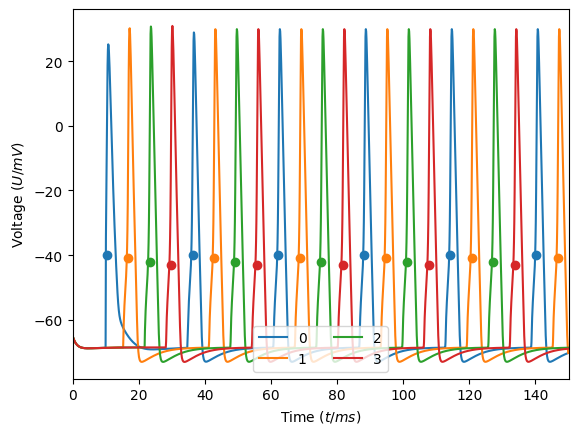

In [46]:
fg, ax = plt.subplots()

for gid, h in enumerate(hdl):
    for data, meta in sim.samples(h):
        ax.plot(data[:, 0], data[:, 1], label=f"{gid}")
        
for gid, sps in enumerate(spikes):
    ax.scatter(sps, [-1*gid - 40 for _ in sps])
        
ax.legend(loc='lower center', ncol=2)
ax.set_xlabel('Time ($t/ms$)')
ax.set_ylabel('Voltage ($U/mV$)')
ax.set_xlim((0, T))

# Discussion

Note how the requirement to assign a place for everything introduces a bit of complexity, but the network structure and setup are identical.
On the other hand, we can now probe different places on the cell, add spatially distributed synapses, and more.
Likewise, we have just scratched the surface of region expressions. 
Please checkout our GUI project if you want to see those in action.

Multiple different cell kinds can coexist in the same simulation, currently we support LIF and cable cells. 
Different cable cells may use different parameters, decors, and/or morphologies.

Arbor has many more features: Stochastic channels, a DSL to write your own channels, diffusion of ions along the dendritic tree, and more.
It supports MPI, multithreading, SIMD, and GPUs.

Enjoy your stay.

PS: You can find us here https://github.com/arbor-sim/arbor and reach all our contact points from there.

# Task (10min)

Try to run this on your own and play a bit. You can try to 
- mix LIF and cable cells
- add more cells
- tweak parameters
- vary parameters, decor, morphology per gid
- ...

Tip: currently the dendrite is just a constant leak current, maybe you can make it more interesting.